<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/Test_ToyDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is an attempt to predict bone age using Xception(pre trained model)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra # เป็นการ import numpy เพื่อเปิดใช้ฟังก์ชันในการทำงาน
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) # เป็น library ในการจัดการ dataframe
import tensorflow as tf #library สำหรับสร้าง machine learning models แบบ open source จาก Google
import datetime,os # datetime ใช้ในการจัด format ของวัน-เวลาให้อยู่ในรูปแบบที่ต้องการ 
import math # เรียกใช้ module เพื่อคำนวณค่าต่างๆ 
import matplotlib.pyplot as plt # เป็น module พื้นฐานที่ใช้ในการสร้างกราฟของ python
import seaborn as sns # เป็นฟังก์ชันเสริมที่ใช้สร้างกราฟให้มีความสวยงามมากขึ้น
from sklearn.model_selection import train_test_split # เป็น library ในการพัฒนาโปรแกรมโดยใช้การเรียนรู้ของเครื่อง

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os # os จัดการเกี่ยวกับไฟล์ต่างๆ ในโฟล์เดอร์

In [4]:
path = '/content/drive/My Drive/Project_Boneage'  # ชี้ว่า data เราอยู่โฟล์เดอร์ไหน

# ***Some Setup***

The cell below creates the pandas dataframes for training and testing.

In [5]:
#loading dataframes # เอาที่อยู่ของไฟล์เชื่อมกับที่อยู่ของไฟล์เรา โดยกำหนดชื่่อไฟล์ที่เราต้องการ
train_path = os.path.join(path,'boneage-training-dataset.csv')
train_df = pd.read_csv(train_path)
test_path = os.path.join(path,'boneage-test-dataset.csv')
test_df = pd.read_csv(test_path)

In [6]:
train_df # แสดง data 'train_df'

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
12606,15605,50,False
12607,15606,113,False
12608,15608,55,False
12609,15609,150,True


In [7]:
test_df # แสดง data 'test_df'

,Case ID,Sex
0,4360,M
1,4361,M
2,4362,M
3,4363,M
4,4364,M
...,...,...
195,4555,F
196,4556,F
197,4557,F
198,4558,F


In [8]:
#appending file extension to id column for both training and testing dataframes
# ต่อท้าย data ใน column 'id' ด้วย .png
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png') # ทำการเปลี่ยน type ใน column 'id' จาก int  เป็น string เพื่อให้สามารถต่อท้ายด้วย .png ได้ # ฟังก์ชันแลมบ์ดาเป็นฟังก์ชันที่ไม่ระบุตัวตนขนาดเล็ก
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 

train_df.head() # แสดงค่าของ train_df บางส่วน

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


# Some EDA and feature engineering follow

In [9]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female') # ทำการเปลี่ยนค่าข้อมูล gender จาก true -> male, false -> female 
train_df['gender']

0        female
1        female
2        female
3          male
4        female
          ...  
12606    female
12607    female
12608    female
12609      male
12610      male
Name: gender, Length: 12611, dtype: object

In [10]:
print(train_df['gender'].value_counts()) #แสดงจำนวนเพศหญิงและเพศชายทั้งหมดใน trian_df

male      6833
female    5778
Name: gender, dtype: int64


In [11]:
train_df.shape # ข้อมูลมีทั้งหมด 12611 จากทั้งหมด 4 column

(12611, 4)

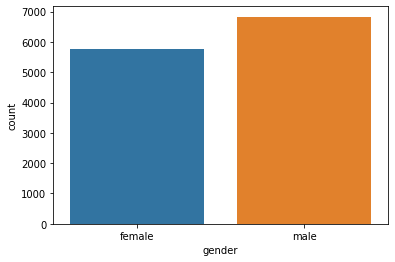

In [12]:
sns.countplot(x = train_df['gender']) # plot กราฟแสดงจำนวนเพศหญิงและเพศชายทั้งหมดใน trian_df

In [13]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months') # ทำการหาอายุที่มากที่สุด และทำการต่อท้ายด้วย months

MAX age: 228 months


In [14]:
#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')  # ทำการหาอายุที่น้อยที่สุด และทำการต่อท้ายด้วย months

MIN age: 1 months


In [15]:
#mean age is # หาค่าเฉลี่ยอายุกระดูก
mean_bone_age = train_df['boneage'].mean() 
print('mean: ' + str(mean_bone_age))

mean: 127.3207517246848


In [16]:
#median bone age # หาค่า median ของอายุกระดูก
print('median: ' +str(train_df['boneage'].median()))

median: 132.0


In [17]:
#standard deviation of boneage # หาค่าส่วนเบี่ยงเบนมาตรฐานของอายุกระดูก
std_bone_age = train_df['boneage'].std()
std_bone_age

41.182021399396326

In [18]:
#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training 
# ทำการหาค่า z-score 
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)
print(train_df.head())

         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


Text(0.5, 1.0, 'Number of children in each age group')

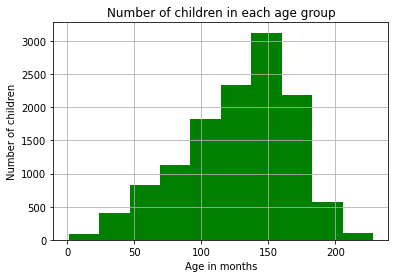

In [19]:
#plotting a histogram for bone ages # plot กราฟ เพื่อดูการกระจายของอายุกระดูก
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

Text(0.5, 1.0, 'Relationship between number of children and bone age z score')

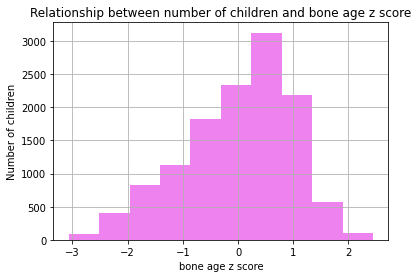

In [20]:
train_df['bone_age_z'].hist(color = 'violet') # plot กราฟ เพื่อดูการกระจายค่า z-score ของอายุกระดูก
plt.xlabel('bone age z score')
plt.ylabel('Number of children')
plt.title('Relationship between number of children and bone age z score')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 86.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


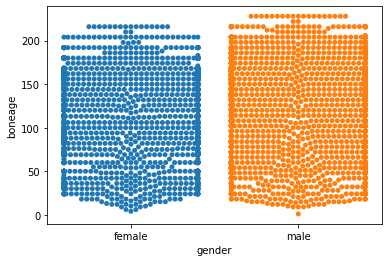

In [21]:
#Relationship between age and gender with a categorical scatter plot (swarmplot) # plot ดูความสัมพันธ์ระหว่างอายุและเพศ
# swarmplot ใช้ plot เพื่อดูการกระจายของข้อมูลโดยที่จุดไม่ทับซ้อนกัน
sns.swarmplot(x = train_df['gender'], y = train_df['boneage'])

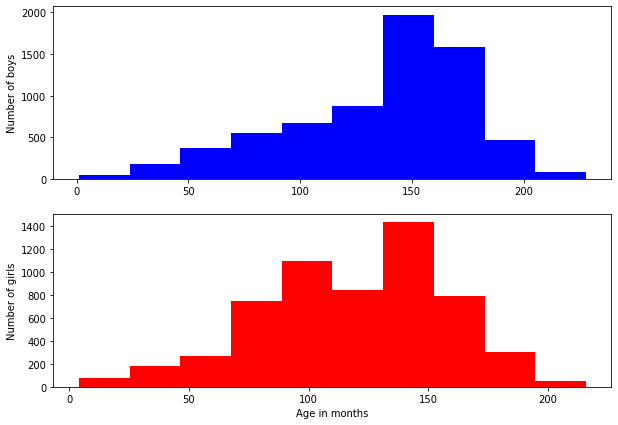

In [22]:
#distribution of age within each gender # plot การกระจายอายุกระดูกของแต่ละเพศ
male = train_df[train_df['gender'] == 'male']
female = train_df[train_df['gender'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('Number of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('Number of girls')
fig.set_size_inches((10,7))

In [23]:
#splitting train dataframe into traininng and validation dataframes #แบ่งข้อมูลออกเป็น 2 ส่วน ด้วยการสุ่ม
df_train, df_valid = train_test_split(train_df, test_size = 0.45, random_state = 0) 
# test_size = 0.2 คือ สัดส่วนของข้อมูลที่ใช้ในการทดสอบ (หากไม่มีการกำหนดค่าจะถูก set = 0.25)# random_state ใช้ในการสุ่มแบ่งกลุ่ม (default=None)

In [24]:
df_train # training

,id,boneage,male,gender,bone_age_z
8437,10937.png,72,True,male,-1.343323
2716,4596.png,132,False,female,0.113624
9669,12330.png,132,False,female,0.113624
10889,13693.png,132,False,female,0.113624
2851,4737.png,180,True,male,1.279181
...,...,...,...,...,...
4859,6961.png,60,True,male,-1.634712
3264,5198.png,106,False,female,-0.517720
9845,12527.png,120,False,female,-0.177766
10799,13593.png,144,False,female,0.405013


In [25]:
df_valid # validation

,id,boneage,male,gender,bone_age_z
5112,7239.png,94,False,female,-0.809109
9866,12548.png,174,True,male,1.133486
2760,4640.png,144,False,female,0.405013
6184,8432.png,168,True,male,0.987791
6803,9121.png,108,True,male,-0.469155
...,...,...,...,...,...
1138,2642.png,84,False,female,-1.051934
6605,8907.png,120,True,male,-0.177766
3281,5218.png,159,True,male,0.769249
3757,5742.png,156,True,male,0.696402


In [26]:
#data_image = os.path.join(path,'boneage-training-dataset') #เอาพาร์ทที่อยู่ในไฟล์มาเชื่อมกับColab
#print(data_image)

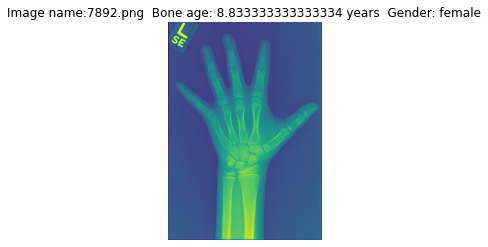

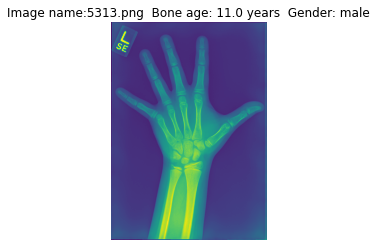

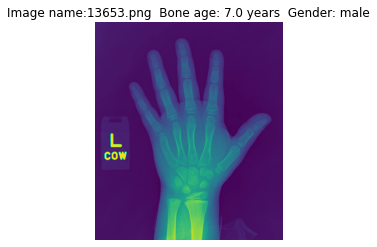

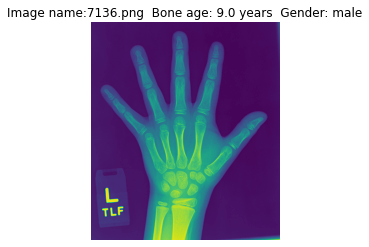

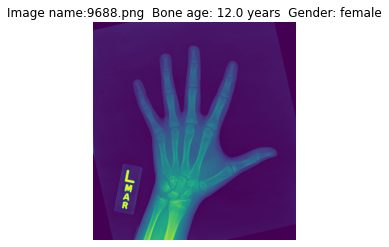

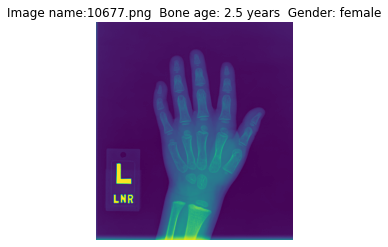

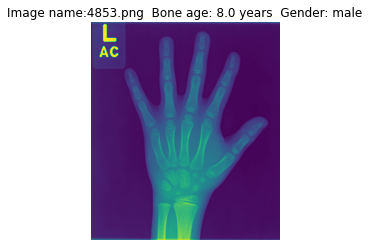

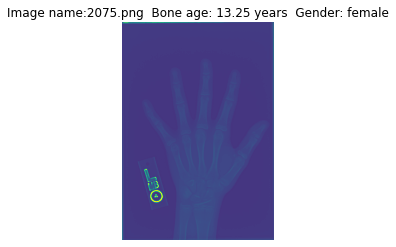

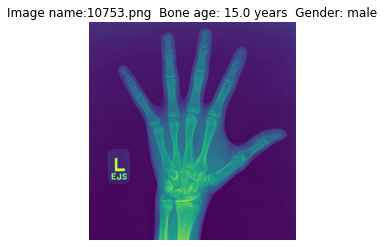

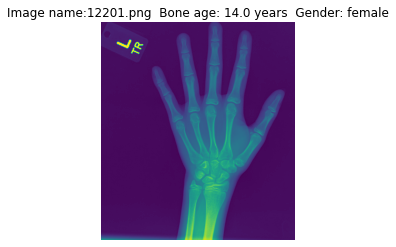

In [27]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
for filename, boneage, gender in train_df[['id','boneage','gender']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ อายุ เพศ)
    img = mpimg.imread(os.path.join(path,'boneage-training-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(img) # แสดงรูปภาพ
    plt.title('Image name:{}  Bone age: {} years  Gender: {}'.format(filename, boneage/12, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.axis('off')
    plt.show()

In [28]:
#library required for image preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from  keras.applications.xception import preprocess_input 

In [29]:
#reducing down the size of the image 
img_size = 256 # ลดขนาดรูปภาพ

In [30]:
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

In [31]:
#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = df_train,
     directory = (os.path.join(path,'boneage-training-dataset/')),
    x_col= 'id',
    y_col= 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 6936 validated image filenames.


In [32]:
#validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe = df_valid,
    directory = (os.path.join(path,'boneage-training-dataset/')),
    x_col = 'id',
    y_col = 'bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'other',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 5675 validated image filenames.


In [33]:
#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = (os.path.join(path,'boneage-test-dataset/')),
    shuffle = True,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

Found 0 images belonging to 0 classes.


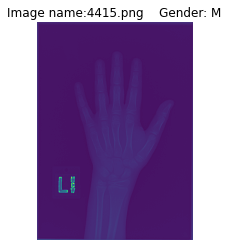

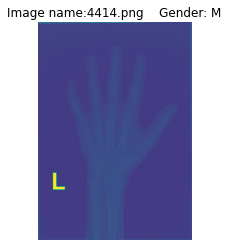

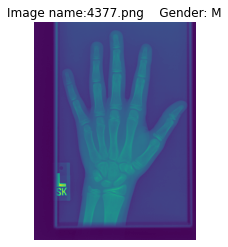

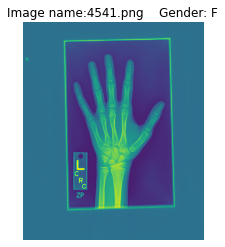

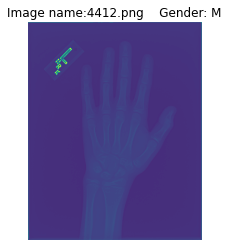

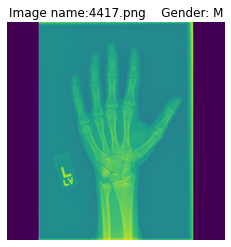

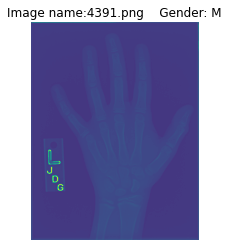

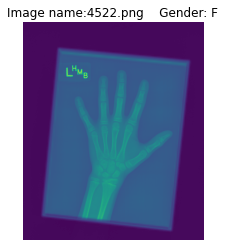

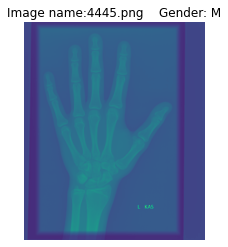

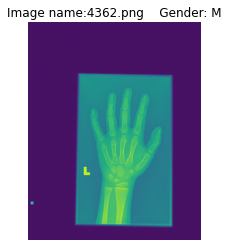

In [34]:
import matplotlib.image as mpimg #นำเข้า library ที่ใช้อ่านรูป
for filename, gender in test_df[['Case ID','Sex']].sample(10).values: #เป็นคำสั่งวนลูปเพื่อแสดงภาพ และข้อมูลของภาพที่เก็บไว้ใน Train_df (ชื่อ เพศ)
    img = mpimg.imread(os.path.join(path,'boneage-test-dataset/')+ filename) # เป็นคำสั่งที่ใช้ในการนำรูปเข้ามา
    plt.imshow(img) # แสดงรูปภาพ
    plt.title('Image name:{}    Gender: {}'.format(filename, gender)) # แสดงหัวเรื่องโดยบอกถึง ชื่อ อายุ(ปี) และเพศ ของแต่ละภาพ
    plt.axis('off')
    plt.show()

In [35]:
test_X, test_Y = next(val_data_generator.flow_from_dataframe( 
                            df_valid, 
                            directory = (os.path.join(path,'boneage-training-dataset/')),
                            x_col = 'id',
                            y_col = 'bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 2523,
                            class_mode = 'other'
                            )) 

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 5675 validated image filenames.


# The function to plot training and validation error as a function of epochs

In [36]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [37]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [38]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential


In [39]:
model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(1, activation = 'linear'))


#compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_______________________________________

In [40]:
# Load the TensorBoard notebook extension # Tensorflow รองรับกับเครื่องที่
%load_ext tensorboard
logs_dir = '.\logs'

In [41]:
import tensorflow as tf
import datetime, os

In [42]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
early_stopping

In [43]:
#model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
mc

In [44]:
#tensorboard callback
logdir = os.path.join(logs_dir,datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback =  TensorBoard(logdir, histogram_freq = 1)
tensorboard_callback

In [45]:
#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
red_lr_plat

In [46]:
callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks

In [ ]:
#fit model
history = model_2.fit(train_generator,
                            validation_data = val_generator,
                            validation_steps = 1,
                            epochs = 15,
                            callbacks= callbacks)
history
%tensorboard --logdir logs
plot_it(history)

Epoch 1/15
217/217 [==============================] - 8093s 37s/step - loss: 0.4445 - mae_in_months: 19.7814 - val_loss: 0.4777 - val_mae_in_months: 21.1133 - lr: 0.0010
Epoch 2/15
217/217 [==============================] - 7623s 35s/step - loss: 0.1638 - mae_in_months: 13.0913 - val_loss: 0.3900 - val_mae_in_months: 20.1466 - lr: 0.0010
Epoch 3/15
 30/217 [===>..........................] - ETA: 1:49:06 - loss: 0.1015 - mae_in_months: 10.4483

# Evaluating the best saved model on the validation data and visualising results!!

In [ ]:
model_2.load_weights('best_model.h5')
pred = mean_bone_age + std_bone_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
test_months = mean_bone_age + std_bone_age*(test_Y)

In [ ]:
ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months, pred, 'r.', label = 'predictions')
ax.plot(test_months, test_months, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

# The plot deviates from the line at very old and very young ages probably because we have less examples for those cases in the dataset

Predicting on test data, we obtain:

In [ ]:
test_generator.reset()
y_pred = model_2.predict_generator(test_generator)
predicted = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predicted)
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions": predicted_months})
results.to_csv("results.csv",index=False)